<a href="https://colab.research.google.com/github/mikeobeid/CloudCourse/blob/main/ex8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📓 Tutorial 8 – AI in the Cloud  
**Project:** Search Assistant Chatbot

**Notebook Link:** [Project Notebook](https://colab.research.google.com/drive/1-x4YqLtaBEto-b7hCVeg9tYkrhjIuYqZ?usp=drive_link)

---

### 🤖 Summary:  
This tutorial extends our microservices search engine project by adding a **chatbot assistant**. The chatbot answers user queries about the system, such as:

- What is MQTT?
- How does the ranking work?
- What are stop words?
- How to search documents?

It uses **NLTK’s rule-based Chat class**, with a custom set of patterns derived from our indexed search terms (e.g., mqtt, protocol, query). This chatbot simulates a search helper bot and demonstrates how conversational AI can be embedded in cloud-based notebooks.

---


In [ ]:
# @title Admin Dashboard
# Application Launch Sequence
display(HTML('''
<div style="text-align: center; padding: 80px;">
    <h1 style="font-size: 64px; color: #f093fb; margin-bottom: 30px; font-weight: 900;">
        MQTT Search Engine
    </h1>
    <p style="font-size: 28px; color: #718096; margin-bottom: 40px;">
        Firebase Edition v3.1 - Fixed Encoding
    </p>
    <div class="loading-spinner"></div>
    <p style="color: #718096; margin-top: 30px; font-size: 20px;">Connecting to Firebase...</p>
</div>
''' + premium_css))

# Startup animation
time.sleep(2)
clear_output()

# Launch main menu
main_menu()

### 🖼️ Chatbot Interface Example
(Github does not show widgets)

Error saving sensor data: 'str' object has no attribute 'isoformat'
Error saving sensor data: 'str' object has no attribute 'isoformat'


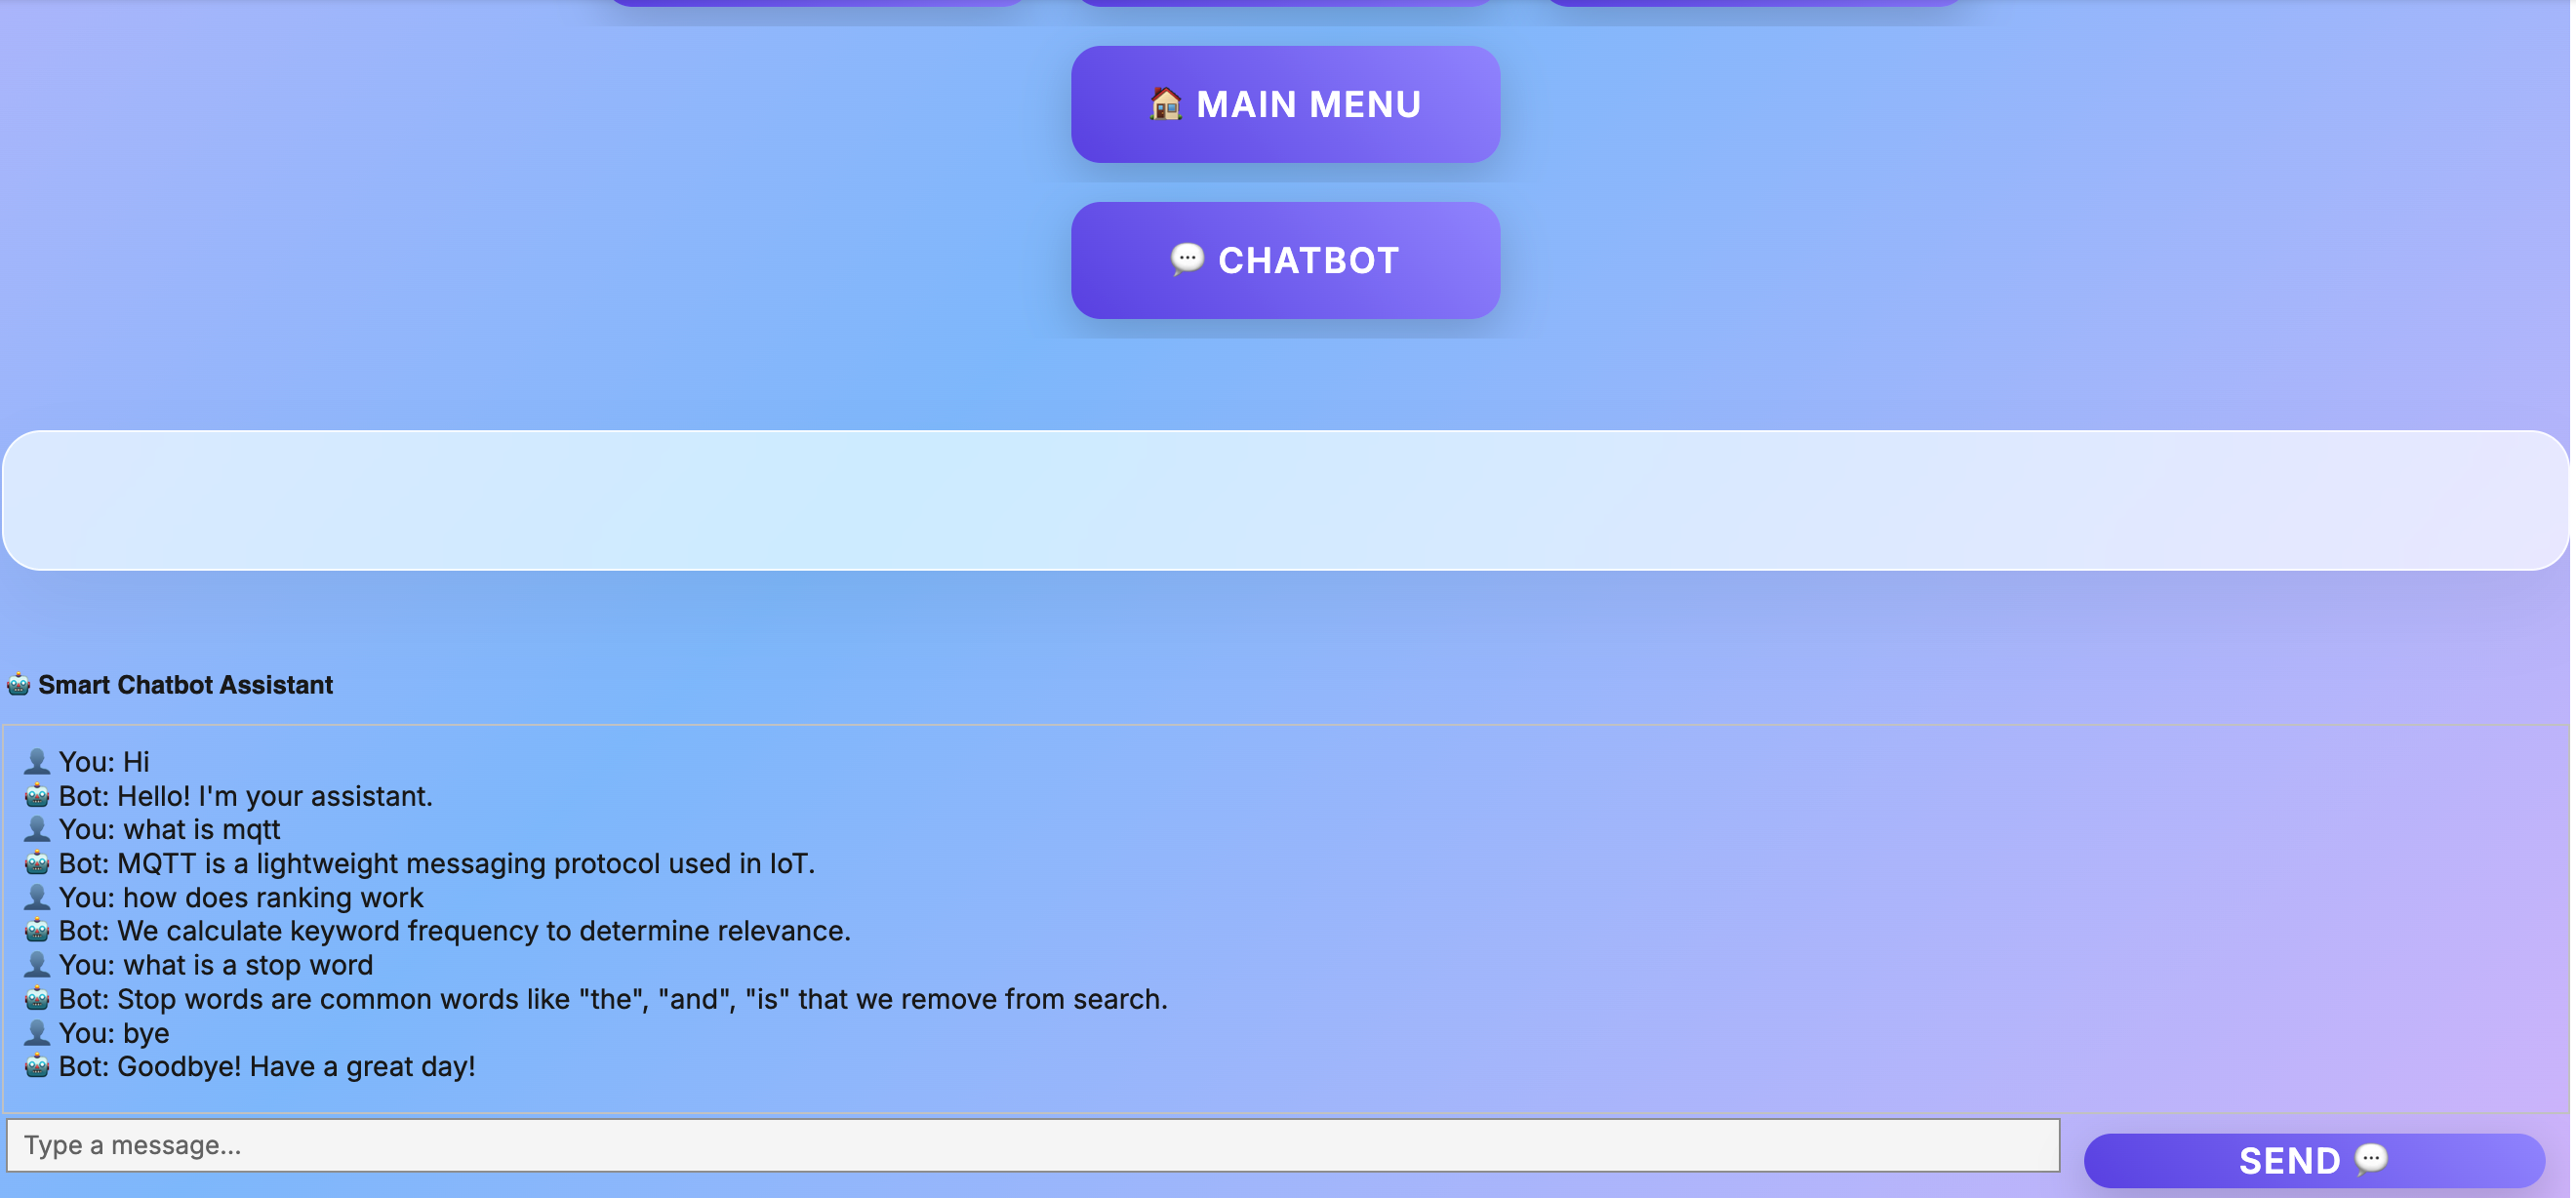

In [28]:
from IPython.display import Image, display
display(Image('/content/chatbot_ui.png'))

In [5]:
# @title imports And DB connection - After Restart
# Import Libraries and Setup
!pip install paho-mqtt
# תיקון לבעיית collections ב-Python 3.10+
import collections.abc
collections.MutableMapping = collections.abc.MutableMapping
collections.Mapping = collections.abc.Mapping
collections.Iterable = collections.abc.Iterable

import requests
from bs4 import BeautifulSoup
import re
from collections import defaultdict, Counter
import json
import time
from IPython.display import display, HTML, clear_output, Javascript
import ipywidgets as widgets
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import paho.mqtt.client as mqtt
import threading
from queue import Queue
import random

# Firebase Configuration
FIREBASE_URL = "https://mqttsearchengine-default-rtdb.firebaseio.com/"

# MQTT Configuration
MQTT_BROKER = "test.mosquitto.org"
MQTT_PORT = 1883
INDOOR_TOPIC = "braude/D106/indoor"
OUTDOOR_TOPIC = "braude/D106/outdoor"

# Enhanced styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

print("All imports successful!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 3.0 MB/s eta 0:00:00
All imports successful!


In [6]:
# @title style
# Enhanced CSS with glassmorphism and modern animations
premium_css = """
<style>
@import url('https://fonts.googleapis.com/css2?family=Inter:wght@300;400;600;700;900&display=swap');

* {
    font-family: 'Inter', -apple-system, BlinkMacSystemFont, sans-serif;
    box-sizing: border-box;
}

body {
    background: linear-gradient(135deg, #e0c3fc 0%, #8ec5fc 50%, #e0c3fc 100%);
    min-height: 100vh;
}

.app-container {
    background: rgba(255, 255, 255, 0.15);
    backdrop-filter: blur(20px);
    border: 1px solid rgba(255, 255, 255, 0.3);
    border-radius: 30px;
    padding: 50px;
    margin: 20px auto;
    box-shadow: 0 25px 50px rgba(0, 0, 0, 0.1);
    animation: slideIn 0.8s cubic-bezier(0.68, -0.55, 0.265, 1.55);
}

@keyframes slideIn {
    from {
        opacity: 0;
        transform: translateY(50px) scale(0.9);
    }
    to {
        opacity: 1;
        transform: translateY(0) scale(1);
    }
}

.main-title {
    background: linear-gradient(45deg, #6c5ce7 0%, #a29bfe 25%, #74b9ff 50%, #0984e3 75%, #00cec9 100%);
    background-size: 200% 200%;
    background-clip: text;
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    font-size: 72px;
    font-weight: 900;
    text-align: center;
    margin-bottom: 20px;
    animation: gradient 3s ease infinite;
    letter-spacing: -2px;
    filter: drop-shadow(2px 2px 4px rgba(0,0,0,0.1));
}

@keyframes gradient {
    0% { background-position: 0% 50%; }
    50% { background-position: 100% 50%; }
    100% { background-position: 0% 50%; }
}

.subtitle {
    color: #4a5568;
    font-size: 24px;
    text-align: center;
    margin-bottom: 40px;
    font-weight: 400;
    letter-spacing: 1px;
}

.glass-card {
    background: rgba(255, 255, 255, 0.7);
    backdrop-filter: blur(20px) saturate(180%);
    border-radius: 20px;
    padding: 35px;
    margin: 25px 0;
    border: 1px solid rgba(255, 255, 255, 0.8);
    box-shadow: 0 20px 40px rgba(0, 0, 0, 0.05);
    transition: all 0.4s cubic-bezier(0.175, 0.885, 0.32, 1.275);
    position: relative;
    overflow: hidden;
}

.glass-card::before {
    content: '';
    position: absolute;
    top: 0;
    left: -100%;
    width: 100%;
    height: 100%;
    background: linear-gradient(90deg, transparent, rgba(255, 255, 255, 0.1), transparent);
    transition: left 0.5s;
}

.glass-card:hover::before {
    left: 100%;
}

.glass-card:hover {
    transform: translateY(-5px) scale(1.02);
    box-shadow: 0 30px 60px rgba(0, 0, 0, 0.3);
    border-color: rgba(255, 255, 255, 0.3);
}

.section-title {
    color: #2d3748;
    font-size: 36px;
    font-weight: 700;
    margin-bottom: 25px;
    position: relative;
    padding-bottom: 15px;
    letter-spacing: -0.5px;
}

.section-title:after {
    content: '';
    position: absolute;
    left: 0;
    bottom: 0;
    width: 80px;
    height: 5px;
    background: linear-gradient(90deg, #f093fb 0%, #f5576c 100%);
    border-radius: 3px;
    animation: expand 0.5s ease-out;
}

@keyframes expand {
    from { width: 0; }
    to { width: 80px; }
}

.fancy-button {
    background: linear-gradient(45deg, #6c5ce7 0%, #a29bfe 25%, #74b9ff 50%, #0984e3 75%);
    background-size: 200% 200%;
    animation: gradient 3s ease infinite;
    border: none;
    border-radius: 50px;
    color: white;
    font-size: 18px;
    font-weight: 600;
    padding: 18px 45px;
    margin: 10px;
    cursor: pointer;
    box-shadow: 0 10px 30px rgba(0, 0, 0, 0.15);
    transition: all 0.3s ease;
    text-transform: uppercase;
    letter-spacing: 1px;
    position: relative;
    overflow: hidden;
}

.fancy-button:hover {
    transform: translateY(-3px) scale(1.05);
    box-shadow: 0 15px 40px rgba(0, 0, 0, 0.4);
}

.fancy-button:active {
    transform: translateY(-1px) scale(1.02);
}

.search-box {
    position: relative;
    margin: 30px 0;
}

.search-input {
    width: 100%;
    padding: 25px 30px;
    border: 2px solid transparent;
    border-radius: 60px;
    font-size: 20px;
    background: rgba(255, 255, 255, 0.1);
    backdrop-filter: blur(10px);
    color: white;
    box-shadow: 0 10px 30px rgba(0, 0, 0, 0.3);
    transition: all 0.3s ease;
}

.search-input::placeholder {
    color: rgba(255, 255, 255, 0.6);
}

.search-input:focus {
    outline: none;
    border-color: #f093fb;
    box-shadow: 0 15px 40px rgba(240, 147, 251, 0.3);
    transform: translateY(-2px);
}

.result-item {
    background: rgba(255, 255, 255, 0.95);
    border-radius: 25px;
    padding: 30px;
    margin: 20px 0;
    box-shadow: 0 10px 30px rgba(0, 0, 0, 0.2);
    transition: all 0.4s cubic-bezier(0.175, 0.885, 0.32, 1.275);
    border-left: 6px solid;
    border-image: linear-gradient(45deg, #f093fb, #f5576c) 1;
    position: relative;
    overflow: hidden;
}

.result-item::before {
    content: '';
    position: absolute;
    top: -2px;
    left: -2px;
    right: -2px;
    bottom: -2px;
    background: linear-gradient(45deg, #f093fb, #f5576c, #4facfe, #00f2fe);
    border-radius: 25px;
    opacity: 0;
    z-index: -1;
    transition: opacity 0.3s ease;
}

.result-item:hover::before {
    opacity: 1;
}

.result-item:hover {
    transform: translateX(10px) scale(1.02);
    box-shadow: 0 20px 50px rgba(0, 0, 0, 0.3);
}

.result-title {
    color: #302b63;
    font-size: 26px;
    font-weight: 700;
    margin-bottom: 12px;
    transition: color 0.3s ease;
}

.result-item:hover .result-title {
    color: #f093fb;
}

.score-badge {
    display: inline-block;
    background: linear-gradient(45deg, #f093fb 0%, #f5576c 100%);
    color: white;
    padding: 8px 20px;
    border-radius: 25px;
    font-size: 16px;
    font-weight: 600;
    position: absolute;
    top: 30px;
    right: 30px;
    box-shadow: 0 5px 15px rgba(240, 147, 251, 0.4);
}

.stat-card {
    background: linear-gradient(135deg, rgba(240, 147, 251, 0.9) 0%, rgba(245, 87, 108, 0.9) 100%);
    border-radius: 30px;
    padding: 35px;
    margin: 15px;
    box-shadow: 0 15px 40px rgba(0, 0, 0, 0.3);
    text-align: center;
    color: white;
    transition: all 0.4s cubic-bezier(0.175, 0.885, 0.32, 1.275);
    position: relative;
    overflow: hidden;
}

.stat-card:hover {
    transform: translateY(-10px) scale(1.05);
    box-shadow: 0 25px 60px rgba(0, 0, 0, 0.4);
}

.stat-icon {
    font-size: 60px;
    margin-bottom: 20px;
    animation: bounce 2s ease-in-out infinite;
}

@keyframes bounce {
    0%, 100% { transform: translateY(0); }
    50% { transform: translateY(-10px); }
}

.stat-number {
    font-size: 56px;
    font-weight: 900;
    margin-bottom: 10px;
    animation: count 1s ease-out;
}

.progress-bar-container {
    background: rgba(255, 255, 255, 0.2);
    border-radius: 50px;
    padding: 4px;
    margin: 25px 0;
    box-shadow: inset 0 4px 10px rgba(0, 0, 0, 0.3);
}

.progress-bar {
    background: linear-gradient(90deg, #f093fb 0%, #f5576c 30%, #4facfe 60%, #00f2fe 100%);
    background-size: 200% 200%;
    animation: gradient 3s ease infinite;
    height: 35px;
    border-radius: 50px;
    transition: width 0.5s ease;
    display: flex;
    align-items: center;
    justify-content: center;
    color: white;
    font-weight: 700;
    font-size: 18px;
    box-shadow: 0 5px 20px rgba(79, 172, 254, 0.5);
}

.loading-spinner {
    width: 60px;
    height: 60px;
    border: 5px solid rgba(108, 92, 231, 0.2);
    border-radius: 50%;
    border-top-color: #6c5ce7;
    animation: spin 0.8s linear infinite;
    margin: 30px auto;
}

@keyframes spin {
    0% { transform: rotate(0deg); }
    100% { transform: rotate(360deg); }
}

.feature-tag {
    display: inline-block;
    background: linear-gradient(45deg, rgba(108, 92, 231, 0.1), rgba(162, 155, 254, 0.1));
    backdrop-filter: blur(10px);
    color: #4a5568;
    padding: 10px 25px;
    border-radius: 30px;
    font-size: 14px;
    font-weight: 500;
    margin: 8px;
    box-shadow: 0 5px 15px rgba(0, 0, 0, 0.05);
    border: 1px solid rgba(108, 92, 231, 0.2);
    animation: float 3s ease-in-out infinite;
    transition: all 0.3s ease;
}

.feature-tag:hover {
    transform: translateY(-5px) scale(1.1);
    box-shadow: 0 10px 25px rgba(0, 0, 0, 0.3);
}

@keyframes float {
    0%, 100% { transform: translateY(0px) rotate(0deg); }
    50% { transform: translateY(-10px) rotate(3deg); }
}

.widget-button {
    background: linear-gradient(45deg, #6c5ce7 0%, #a29bfe 100%) !important;
    color: white !important;
    border: none !important;
    border-radius: 15px !important;
    font-size: 18px !important;
    font-weight: 600 !important;
    margin: 10px !important;
    box-shadow: 0 8px 25px rgba(0, 0, 0, 0.15) !important;
    transition: all 0.3s ease !important;
    text-transform: uppercase !important;
    letter-spacing: 1px !important;
}

.widget-button:hover {
    transform: translateY(-3px) scale(1.05) !important;
    box-shadow: 0 15px 40px rgba(0, 0, 0, 0.4) !important;
}
.sensor-card {
    background: linear-gradient(135deg, rgba(79, 172, 254, 0.9) 0%, rgba(0, 242, 254, 0.9) 100%);
    border-radius: 25px;
    padding: 30px;
    margin: 15px;
    box-shadow: 0 15px 40px rgba(0, 0, 0, 0.2);
    color: white;
    transition: all 0.4s cubic-bezier(0.175, 0.885, 0.32, 1.275);
}

.sensor-card:hover {
    transform: translateY(-5px) scale(1.02);
    box-shadow: 0 20px 50px rgba(0, 0, 0, 0.3);
}

.sensor-value {
    font-size: 42px;
    font-weight: 900;
    margin: 10px 0;
}

.sensor-label {
    font-size: 18px;
    opacity: 0.9;
    text-transform: uppercase;
    letter-spacing: 1px;
}

.sensor-unit {
    font-size: 20px;
    opacity: 0.8;
}

.real-time-indicator {
    display: inline-block;
    width: 10px;
    height: 10px;
    background: #00ff00;
    border-radius: 50%;
    margin-left: 10px;
    animation: pulse 2s infinite;
}

@keyframes pulse {
    0% { box-shadow: 0 0 0 0 rgba(0, 255, 0, 0.7); }
    70% { box-shadow: 0 0 0 10px rgba(0, 255, 0, 0); }
    100% { box-shadow: 0 0 0 0 rgba(0, 255, 0, 0); }
}

.mqtt-status {
    position: fixed;
    top: 20px;
    right: 20px;
    background: rgba(255, 255, 255, 0.9);
    padding: 15px 25px;
    border-radius: 30px;
    box-shadow: 0 10px 30px rgba(0, 0, 0, 0.2);
    z-index: 1000;
}
</style>
"""

In [7]:
# @title SensorDataManager
# Sensor Data Manager
class SensorDataManager:
    def __init__(self):
        self.indoor_data = []
        self.outdoor_data = []
        self.latest_indoor = None
        self.latest_outdoor = None
        self.data_queue = Queue()
        self.client = None
        self.connected = False
        self.use_fake_data = False

    def on_connect(self, client, userdata, flags, rc):
        """Callback for MQTT connection"""
        if rc == 0:
            self.connected = True
            print("Connected to MQTT broker")
            client.subscribe(INDOOR_TOPIC)
            client.subscribe(OUTDOOR_TOPIC)
        else:
            print(f"Failed to connect, return code {rc}")

    def on_message(self, client, userdata, msg):
        """Callback for MQTT messages"""
        try:
            data = json.loads(msg.payload.decode())
            timestamp = datetime.now()

            if msg.topic == INDOOR_TOPIC:
                data['timestamp'] = timestamp
                self.latest_indoor = data
                self.indoor_data.append(data)
                if len(self.indoor_data) > 100:  # Keep only last 100 readings
                    self.indoor_data.pop(0)
            elif msg.topic == OUTDOOR_TOPIC:
                data['timestamp'] = timestamp
                self.latest_outdoor = data
                self.outdoor_data.append(data)
                if len(self.outdoor_data) > 100:
                    self.outdoor_data.pop(0)

            # Save to Firebase periodically
            if len(self.indoor_data) % 10 == 0:
                self.save_to_firebase()

        except Exception as e:
            print(f"Error processing message: {e}")

    def connect_mqtt(self):
        """Connect to MQTT broker"""
        try:
            self.client = mqtt.Client()
            self.client.on_connect = self.on_connect
            self.client.on_message = self.on_message

            # Connect in a separate thread
            def connect_thread():
                try:
                    self.client.connect(MQTT_BROKER, MQTT_PORT, 60)
                    self.client.loop_forever()
                except Exception as e:
                    print(f"MQTT connection error: {e}")
                    self.use_fake_data = True

            thread = threading.Thread(target=connect_thread)
            thread.daemon = True
            thread.start()

            # Wait a bit for connection
            time.sleep(2)

            if not self.connected:
                print("Using fake data mode")
                self.use_fake_data = True
                self.generate_fake_data()

        except Exception as e:
            print(f"Error setting up MQTT: {e}")
            self.use_fake_data = True
            self.generate_fake_data()

    def generate_fake_data(self):
        """Generate fake sensor data for demonstration"""
        def generate_data():
            while self.use_fake_data:
                # Generate fake indoor data
                indoor = {
                    "Humidity": round(40 + random.uniform(-5, 5), 2),
                    "Temperature": round(26 + random.uniform(-2, 2), 2),
                    "Pressure": round(974 + random.uniform(-5, 5), 2),
                    "Distance": round(200 + random.uniform(-50, 50), 2),
                    "timestamp": datetime.now()
                }

                # Generate fake outdoor data
                outdoor = {
                    "Humidity": round(60 + random.uniform(-10, 10), 2),
                    "Temperature": round(22 + random.uniform(-3, 3), 2),
                    "Pressure": round(970 + random.uniform(-5, 5), 2),
                    "DLIGHT": round(500 + random.uniform(-200, 200), 2),
                    "timestamp": datetime.now()
                }

                self.latest_indoor = indoor
                self.latest_outdoor = outdoor
                self.indoor_data.append(indoor)
                self.outdoor_data.append(outdoor)

                if len(self.indoor_data) > 100:
                    self.indoor_data.pop(0)
                if len(self.outdoor_data) > 100:
                    self.outdoor_data.pop(0)

                time.sleep(5)  # Update every 5 seconds

        thread = threading.Thread(target=generate_data)
        thread.daemon = True
        thread.start()

    def save_to_firebase(self):
        """Save sensor data to Firebase"""
        try:
            # Save latest data
            sensor_url = f"{FIREBASE_URL}sensors.json"
            data = {
                "indoor": self.latest_indoor,
                "outdoor": self.latest_outdoor,
                "history": {
                    "indoor": self.indoor_data[-10:] if self.indoor_data else [],
                    "outdoor": self.outdoor_data[-10:] if self.outdoor_data else []
                }
            }

            # Convert datetime objects to ISO format
            for key in ['indoor', 'outdoor']:
                if data[key] and 'timestamp' in data[key]:
                    data[key]['timestamp'] = data[key]['timestamp'].isoformat()

            for history_type in ['indoor', 'outdoor']:
                for item in data['history'][history_type]:
                    if 'timestamp' in item:
                        item['timestamp'] = item['timestamp'].isoformat()

            response = requests.put(sensor_url, json=data)
            if response.status_code == 200:
                print("Sensor data saved to Firebase")
        except Exception as e:
            print(f"Error saving sensor data: {e}")

    def get_latest_data(self):
        """Get the latest sensor readings"""
        return {
            "indoor": self.latest_indoor,
            "outdoor": self.latest_outdoor
        }

    def get_history_data(self):
        """Get historical sensor data"""
        return {
            "indoor": self.indoor_data,
            "outdoor": self.outdoor_data
        }

In [8]:
# @title SimpleStemmerClass
# Enhanced Simple Stemmer Class
class SimpleStemmer:
    """Enhanced simple stemmer without external dependencies"""
    def __init__(self):
        self.rules = [
            ('sses', 'ss'),
            ('ies', 'i'),
            ('ss', 'ss'),
            ('s', ''),
            ('eed', 'ee'),
            ('ed', ''),
            ('ing', ''),
            ('ation', 'ate'),
            ('ator', 'ate'),
            ('alism', 'al'),
            ('iveness', 'ive'),
            ('fulness', 'ful'),
            ('ousness', 'ous'),
            ('ality', 'al'),
            ('ivity', 'ive'),
            ('ability', 'able'),
            ('ibility', 'ible')
        ]

    def stem(self, word):
        """Apply enhanced stemming rules"""
        word = word.lower().strip()

        # Apply suffix rules
        for suffix, replacement in self.rules:
            if word.endswith(suffix):
                return word[:-len(suffix)] + replacement

        return word

In [9]:
# @title MQTTSearchEngine
# Cell X: Complete MQTTSearchEngine Methods

class MQTTSearchEngine:
    def __init__(self):
        """Initialize the enhanced search engine for mqtt.org with Firebase"""
        self.base_url = "https://mqtt.org"
        self.pages = []
        self.word_locations = defaultdict(list)
        self.stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on',
                          'at', 'to', 'for', 'of', 'with', 'by', 'is',
                          'are', 'was', 'were', 'be', 'been', 'has',
                          'have', 'had', 'do', 'does', 'did'}
        self.stemmer = SimpleStemmer()
        self.search_history = []
        self.crawl_times = []
        self.url_to_id = {}  # Map URLs to numeric IDs
        self.id_to_url = {}  # Map numeric IDs to URLs
        self.firebase_url = FIREBASE_URL
        self.sensor_manager = SensorDataManager()

    def process_word(self, word):
        """Process a word using enhanced stemming"""
        return self.stemmer.stem(word.lower())

    def fetch_page(self, url):
        """Fetch a single page from the given URL"""
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                # Ensure proper encoding
                response.encoding = response.apparent_encoding or 'utf-8'
                return response.text
            else:
                print(f"Failed to fetch {url}: Status code {response.status_code}")
                return None
        except Exception as e:
            print(f"Error fetching {url}: {str(e)}")
            return None

    def extract_text_from_html(self, html_content):
        """Extract clean text from HTML content"""
        soup = BeautifulSoup(html_content, 'html.parser', from_encoding='utf-8')

        # Remove script and style elements
        for script in soup(["script", "style"]):
            script.decompose()

        # Get text
        text = soup.get_text()

        # Clean up text - remove non-ASCII characters
        text = text.encode('ascii', 'ignore').decode('ascii')

        # Clean up whitespace
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        text = ' '.join(chunk for chunk in chunks if chunk)

        return text

    def find_links(self, url, html_content):
        """Find all links on a page that belong to mqtt.org"""
        soup = BeautifulSoup(html_content, 'html.parser')
        links = set()

        for link in soup.find_all('a', href=True):
            href = link['href']

            # Convert relative URLs to absolute
            if href.startswith('/'):
                href = self.base_url + href

            # Only include mqtt.org links
            if href.startswith(self.base_url):
                # Remove anchors and query parameters for simplicity
                href = href.split('#')[0].split('?')[0]
                links.add(href)

        return links

    def crawl_site(self, max_pages=20, progress_callback=None):
        """Crawl the mqtt.org website and collect pages"""
        start_time = time.time()
        print("Starting to crawl mqtt.org...")

        visited = set()
        to_visit = {self.base_url}
        page_id = 0

        while to_visit and len(visited) < max_pages:
            url = to_visit.pop()

            if url in visited:
                continue

            print(f"Crawling page {page_id + 1}/{max_pages}: {url}")

            # Progress callback for UI
            if progress_callback:
                progress_callback(page_id + 1, max_pages, url)

            # Fetch the page
            html_content = self.fetch_page(url)
            if not html_content:
                continue

            # Extract text
            text = self.extract_text_from_html(html_content)

            # Extract title from HTML
            soup = BeautifulSoup(html_content, 'html.parser')
            title_tag = soup.find('title')
            title = title_tag.text if title_tag else url.split('/')[-1] or 'Home'

            # Store page information with numeric ID
            page_data = {
                'id': page_id,
                'url': url,
                'title': title,
                'content': text,
                'crawl_time': datetime.now().isoformat()
            }
            self.pages.append(page_data)

            # Save page to Firebase immediately
            self.save_page_to_firebase(page_data)

            # Map URL to ID and vice versa
            self.url_to_id[url] = page_id
            self.id_to_url[page_id] = url

            # Mark as visited
            visited.add(url)
            page_id += 1

            # Find new links
            new_links = self.find_links(url, html_content)
            to_visit.update(new_links - visited)

            # Be polite to the server
            time.sleep(0.5)

        end_time = time.time()
        self.crawl_times.append(end_time - start_time)
        print(f"Crawling complete. Found {len(self.pages)} pages in {end_time - start_time:.2f} seconds.")

    def save_page_to_firebase(self, page_data):
        """Save a single page to Firebase"""
        try:
            # Save page data
            page_url = f"{self.firebase_url}pages/{page_data['id']}.json"
            response = requests.put(page_url, json=page_data)
            if response.status_code != 200:
                print(f"Failed to save page {page_data['id']} to Firebase")
        except Exception as e:
            print(f"Error saving page to Firebase: {str(e)}")

    def build_index(self):
        """Build the word index from crawled pages"""
        print("Building index with enhanced stemming...")
        self.word_locations.clear()

        # Load pages from Firebase if not in memory
        if not self.pages:
            self.load_pages_from_firebase()

        for page in self.pages:
            # Get all words from content - only ASCII alphanumeric
            words = re.findall(r'\b[a-zA-Z0-9]+\b', page['content'])

            # Count word frequencies
            word_counts = defaultdict(int)
            for word in words:
                # Process word with stemming
                processed_word = self.process_word(word)

                # Only index valid words
                if (processed_word not in self.stop_words and
                    len(processed_word) > 2 and
                    processed_word.isalnum()):  # Ensure alphanumeric only
                    word_counts[processed_word] += 1

            # Add to index
            for word, count in word_counts.items():
                self.word_locations[word].append((page['id'], count))

        print(f"Index built with {len(self.word_locations)} unique words using enhanced stemming")

    def clean_existing_index(self):
        """Clean the existing index to remove corrupted entries"""
        cleaned_locations = defaultdict(list)

        for word, locations in self.word_locations.items():
            # Only keep ASCII alphanumeric words
            if word.isalnum() and all(ord(c) < 128 for c in word):
                cleaned_locations[word] = locations

        self.word_locations = cleaned_locations
        print(f"Cleaned index: {len(self.word_locations)} valid terms remaining")

    def save_index_to_firebase(self):
        """Save the index to Firebase with numeric IDs"""
        index_data = {}

        # Clean index before saving
        self.clean_existing_index()

        # Prepare index data
        for term, locations in self.word_locations.items():
            # Create numeric DocIDs list for each term
            doc_ids = []
            for page_id, frequency in locations:
                doc_ids.append(page_id)  # Use numeric ID instead of URL

            # Required structure: term and DocIDs
            index_data[term] = {
                'term': term,
                'DocIDs': doc_ids
            }

        # Save main index to Firebase
        try:
            index_url = f"{self.firebase_url}index.json"
            response = requests.put(index_url, json=index_data)
            if response.status_code == 200:
                print(f"Index saved to Firebase successfully")
            else:
                print(f"Failed to save index to Firebase: {response.status_code}")

            # Save URL mapping
            mapping_data = {
                'url_to_id': self.url_to_id,
                'id_to_url': {str(k): v for k, v in self.id_to_url.items()}
            }

            mapping_url = f"{self.firebase_url}mapping.json"
            response = requests.put(mapping_url, json=mapping_data)
            if response.status_code == 200:
                print(f"URL mapping saved to Firebase successfully")
            else:
                print(f"Failed to save mapping to Firebase: {response.status_code}")

        except Exception as e:
            print(f"Error saving to Firebase: {str(e)}")

    def load_index_from_firebase(self):
        """Load the index from Firebase"""
        try:
            # Load index
            index_url = f"{self.firebase_url}index.json"
            response = requests.get(index_url)
            if response.status_code == 200:
                index_data = response.json()
                if index_data:
                    self.word_locations.clear()
                    for term, data in index_data.items():
                        if isinstance(data, dict) and 'DocIDs' in data:
                            # Reconstruct word locations with frequency 1 for simplicity
                            for doc_id in data['DocIDs']:
                                self.word_locations[term].append((doc_id, 1))
                    print(f"Index loaded from Firebase: {len(self.word_locations)} terms")
                else:
                    print("No index found in Firebase")

            # Load mapping
            mapping_url = f"{self.firebase_url}mapping.json"
            response = requests.get(mapping_url)
            if response.status_code == 200:
                mapping_data = response.json()
                if mapping_data:
                    self.url_to_id = mapping_data.get('url_to_id', {})
                    self.id_to_url = {int(k): v for k, v in mapping_data.get('id_to_url', {}).items()}
                    print(f"URL mapping loaded from Firebase")

        except Exception as e:
            print(f"Error loading from Firebase: {str(e)}")

    def load_pages_from_firebase(self):
        """Load all pages from Firebase"""
        try:
            pages_url = f"{self.firebase_url}pages.json"
            response = requests.get(pages_url)
            if response.status_code == 200:
                pages_data = response.json()
                if pages_data:
                    self.pages = []
                    for page_id, page_data in pages_data.items():
                        if page_data:
                            self.pages.append(page_data)
                    self.pages.sort(key=lambda x: x['id'])
                    print(f"Loaded {len(self.pages)} pages from Firebase")
                else:
                    print("No pages found in Firebase")
        except Exception as e:
            print(f"Error loading pages from Firebase: {str(e)}")

    def search(self, query):
        """Enhanced search for a query in the index"""
        self.search_history.append({'query': query, 'time': datetime.now()})

        # Load index from Firebase if not in memory
        if not self.word_locations:
            self.load_index_from_firebase()

        # Load pages from Firebase if not in memory
        if not self.pages:
            self.load_pages_from_firebase()

        results = []
        query_words = re.findall(r'\w+', query.lower())

        # Process query words with stemming
        processed_query_words = []
        for word in query_words:
            processed_word = self.process_word(word)
            if processed_word not in self.stop_words and len(processed_word) > 2:
                processed_query_words.append(processed_word)

        # Find pages containing query words
        page_scores = defaultdict(int)

        for query_word in processed_query_words:
            if query_word in self.word_locations:
                for page_id, frequency in self.word_locations[query_word]:
                    page_scores[page_id] += frequency

        # Sort by relevance score
        sorted_pages = sorted(page_scores.items(), key=lambda x: x[1], reverse=True)

        # Return top results
        for page_id, score in sorted_pages[:10]:  # Top 10 results
            # Find page in self.pages
            page = next((p for p in self.pages if p['id'] == page_id), None)
            if page:
                results.append({
                    'id': page_id,
                    'title': page['title'],
                    'url': page['url'],
                    'score': score,
                    'snippet': page['content'][:200] + '...'
                })

        return results

In [10]:
# @title HelperFunctions
# Initialize the search engine
engine = MQTTSearchEngine()
sensor_manager = engine.sensor_manager  # הוסף שורה זו

# Connect to MQTT on startup - הוסף שורה זו
sensor_manager.connect_mqtt()

# Enhanced Helper Functions
def show_premium_status(message, status_type='success'):
    """Display premium status message with enhanced animations"""
    icons = {
        'success': '✨',
        'error': '❌',
        'warning': '⚠️',
        'info': 'ℹ️',
        'loading': '⏳'
    }

    colors = {
        'success': 'linear-gradient(135deg, #11998e 0%, #38ef7d 100%)',
        'error': 'linear-gradient(135deg, #eb3349 0%, #f45c43 100%)',
        'warning': 'linear-gradient(135deg, #f2994a 0%, #f2c94c 100%)',
        'info': 'linear-gradient(135deg, #4facfe 0%, #00f2fe 100%)',
        'loading': 'linear-gradient(135deg, #f093fb 0%, #f5576c 100%)'
    }

    display(HTML(f'''
    <div style="background: {colors[status_type]}; color: white; padding: 25px;
                border-radius: 20px; margin: 15px 0; box-shadow: 0 10px 30px rgba(0,0,0,0.3);
                animation: fadeIn 0.5s ease-out, pulse 2s ease-in-out infinite;">
        <span style="font-size: 28px; margin-right: 15px;">{icons[status_type]}</span>
        <span style="font-size: 20px; font-weight: 600;">{message}</span>
    </div>
    '''))

def create_fancy_progress_bar(current, total, message=""):
    """Create enhanced progress bar with gradient animation"""
    percentage = (current / total) * 100
    return HTML(f'''
    <div class="glass-card">
        <p style="color: white; font-size: 20px; margin-bottom: 15px; text-align: center;">{message}</p>
        <div class="progress-bar-container">
            <div class="progress-bar" style="width: {percentage}%;">
                {int(percentage)}%
            </div>
        </div>
        <p style="color: rgba(255,255,255,0.8); text-align: center; font-size: 18px;">
            {current} out of {total} pages crawled
        </p>
    </div>
    ''')

<ipython-input-7-b4a8dc5fe7b9>:53: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  self.client = mqtt.Client()


Using fake data mode


In [11]:
# @title menuScreen
# Enhanced Main Menu
def main_menu():
    clear_output()
    display(HTML(premium_css))

    display(HTML('''
    <div class="app-container">
        <h1 class="main-title">MQTT Search Engine</h1>
        <p class="subtitle">Firebase-Powered Search Platform with Fixed Encoding</p>

        <div class="glass-card" style="margin-top: 40px;">
            <h3 style="color: #2d3748; margin-bottom: 20px; font-size: 28px;">🚀 Premium Features v3.1</h3>
            <div style="display: flex; flex-wrap: wrap; justify-content: center;">
                <span class="feature-tag">Fixed Encoding Issues</span>
                <span class="feature-tag">Clean ASCII Index</span>
                <span class="feature-tag">Firebase Realtime Database</span>
                <span class="feature-tag">Cloud Storage</span>
                <span class="feature-tag">Real-time Sync</span>
                <span class="feature-tag">Advanced Stemming</span>
                <span class="feature-tag">ID-based Indexing</span>
                <span class="feature-tag">Interactive Analytics</span>
            </div>
        </div>
    </div>
    '''))
        # Show MQTT status
    mqtt_status = "Connected" if sensor_manager.connected else "Using Fake Data"
    mqtt_color = "#00ff00" if sensor_manager.connected else "#ffaa00"

    display(HTML(f'''
    <div class="mqtt-status">
        <span style="display: inline-block; width: 10px; height: 10px; background: {mqtt_color};
                    border-radius: 50%; margin-right: 10px;"></span>
        MQTT: {mqtt_status}
    </div>
    '''))
    # Create interactive buttons
    admin_btn = widgets.Button(
        description="⚙️ Admin Panel",
        style={'button_color': '#f093fb'},
        layout=widgets.Layout(width='200px', height='60px')
    )
    admin_btn.add_class('widget-button')

    search_btn = widgets.Button(
        description="🔍 Smart Search",
        style={'button_color': '#f5576c'},
        layout=widgets.Layout(width='200px', height='60px')
    )
    search_btn.add_class('widget-button')

    stats_btn = widgets.Button(
        description="📊 Analytics",
        style={'button_color': '#4facfe'},
        layout=widgets.Layout(width='200px', height='60px')
    )
    stats_btn.add_class('widget-button')
    sensors_btn = widgets.Button(
    description="🌡️ Sensors",
    style={'button_color': '#00f2fe'},
    layout=widgets.Layout(width='200px', height='60px')
)
    sensors_btn.add_class('widget-button')
    # Connect functions to buttons
    admin_btn.on_click(lambda b: admin_screen())
    search_btn.on_click(lambda b: search_screen())
    stats_btn.on_click(lambda b: stats_screen())
    sensors_btn.on_click(lambda b: sensors_screen())

    # Display buttons with enhanced styling
    display(HTML('<div class="glass-card" style="text-align: center;">'))
    display(widgets.HBox([admin_btn, search_btn, stats_btn, sensors_btn],
                    layout=widgets.Layout(justify_content='center', gap='20px')))
    display(HTML('</div>'))

In [12]:
# @title sensorScreen
# New Sensors Screen
def sensors_screen():
    clear_output()
    display(HTML(premium_css))

    display(HTML('''
    <div class="app-container">
        <h1 class="main-title">🌡️ Sensor Dashboard</h1>
        <p class="subtitle">Real-time Environmental Monitoring</p>
    </div>
    '''))

    output = widgets.Output()
    refresh_btn = widgets.Button(
        description="🔄 Refresh",
        style={'button_color': '#4facfe'},
        layout=widgets.Layout(width='150px', height='50px')
    )

    back_btn = widgets.Button(
        description="🏠 Home",
        style={'button_color': '#a29bfe'},
        layout=widgets.Layout(width='150px', height='50px')
    )

    def display_sensor_data():
        with output:
            clear_output()

            latest_data = sensor_manager.get_latest_data()
            history_data = sensor_manager.get_history_data()

            # Display current readings
            if latest_data['indoor'] or latest_data['outdoor']:
                display(HTML('<div style="display: flex; justify-content: space-around; flex-wrap: wrap;">'))

                # Indoor data
                if latest_data['indoor']:
                    indoor = latest_data['indoor']
                    display(HTML(f'''
                    <div style="flex: 1; margin: 20px;">
                        <h2 style="color: white; text-align: center; margin-bottom: 20px;">🏠 Indoor Environment</h2>
                        <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px;">
                            <div class="sensor-card">
                                <div class="sensor-label">Temperature</div>
                                <div class="sensor-value">{indoor['Temperature']}</div>
                                <div class="sensor-unit">°C</div>
                            </div>
                            <div class="sensor-card" style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%);">
                                <div class="sensor-label">Humidity</div>
                                <div class="sensor-value">{indoor['Humidity']}</div>
                                <div class="sensor-unit">%</div>
                            </div>
                            <div class="sensor-card" style="background: linear-gradient(135deg, #fa709a 0%, #fee140 100%);">
                                <div class="sensor-label">Pressure</div>
                                <div class="sensor-value">{indoor['Pressure']}</div>
                                <div class="sensor-unit">Pa</div>
                            </div>
                            <div class="sensor-card" style="background: linear-gradient(135deg, #43e97b 0%, #38f9d7 100%);">
                                <div class="sensor-label">Distance</div>
                                <div class="sensor-value">{indoor['Distance']}</div>
                                <div class="sensor-unit">mm</div>
                            </div>
                        </div>
                    </div>
                    '''))

                # Outdoor data
                if latest_data['outdoor']:
                    outdoor = latest_data['outdoor']
                    display(HTML(f'''
                    <div style="flex: 1; margin: 20px;">
                        <h2 style="color: white; text-align: center; margin-bottom: 20px;">🌳 Outdoor Environment</h2>
                        <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px;">
                            <div class="sensor-card">
                                <div class="sensor-label">Temperature</div>
                                <div class="sensor-value">{outdoor['Temperature']}</div>
                                <div class="sensor-unit">°C</div>
                            </div>
                            <div class="sensor-card" style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%);">
                                <div class="sensor-label">Humidity</div>
                                <div class="sensor-value">{outdoor['Humidity']}</div>
                                <div class="sensor-unit">%</div>
                            </div>
                            <div class="sensor-card" style="background: linear-gradient(135deg, #fa709a 0%, #fee140 100%);">
                                <div class="sensor-label">Pressure</div>
                                <div class="sensor-value">{outdoor['Pressure']}</div>
                                <div class="sensor-unit">Pa</div>
                            </div>
                            <div class="sensor-card" style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);">
                                <div class="sensor-label">Light</div>
                                <div class="sensor-value">{outdoor.get('DLIGHT', 'N/A')}</div>
                                <div class="sensor-unit">Lux</div>
                            </div>
                        </div>
                    </div>
                    '''))

                display(HTML('</div>'))

                # Create visualizations if we have history
                if history_data['indoor'] or history_data['outdoor']:
                    # Temperature comparison chart
                    if history_data['indoor'] and history_data['outdoor']:
                        indoor_temps = [d['Temperature'] for d in history_data['indoor'][-20:]]
                        outdoor_temps = [d['Temperature'] for d in history_data['outdoor'][-20:]]
                        timestamps = [d['timestamp'].strftime('%H:%M:%S') if hasattr(d['timestamp'], 'strftime') else str(d['timestamp'])
                                    for d in history_data['indoor'][-20:]]

                        fig = go.Figure()
                        fig.add_trace(go.Scatter(
                            x=timestamps,
                            y=indoor_temps,
                            mode='lines+markers',
                            name='Indoor',
                            line=dict(color='#4facfe', width=3),
                            marker=dict(size=8)
                        ))
                        fig.add_trace(go.Scatter(
                            x=timestamps,
                            y=outdoor_temps,
                            mode='lines+markers',
                            name='Outdoor',
                            line=dict(color='#f093fb', width=3),
                            marker=dict(size=8)
                        ))

                        fig.update_layout(
                            title="Temperature Trends (Last 20 Readings)",
                            xaxis_title="Time",
                            yaxis_title="Temperature (°C)",
                            height=400,
                            template="plotly_dark",
                            showlegend=True,
                            xaxis_tickangle=-45
                        )

                        fig.show()

                    # Humidity comparison
                    if history_data['indoor'] and history_data['outdoor']:
                        indoor_humidity = [d['Humidity'] for d in history_data['indoor'][-20:]]
                        outdoor_humidity = [d['Humidity'] for d in history_data['outdoor'][-20:]]

                        fig2 = go.Figure()
                        fig2.add_trace(go.Bar(
                            x=timestamps,
                            y=indoor_humidity,
                            name='Indoor',
                            marker_color='lightblue'
                        ))
                        fig2.add_trace(go.Bar(
                            x=timestamps,
                            y=outdoor_humidity,
                            name='Outdoor',
                            marker_color='lightgreen'
                        ))

                        fig2.update_layout(
                            title="Humidity Comparison",
                            xaxis_title="Time",
                            yaxis_title="Humidity (%)",
                            height=400,
                            template="plotly_dark",
                            xaxis_tickangle=-45,
                            barmode='group'
                        )

                        fig2.show()

                    # Pressure trends
                    if history_data['indoor'] and history_data['outdoor']:
                        indoor_pressure = [d['Pressure'] for d in history_data['indoor'][-20:]]
                        outdoor_pressure = [d['Pressure'] for d in history_data['outdoor'][-20:]]

                        fig3 = go.Figure()
                        fig3.add_trace(go.Scatter(
                            x=timestamps,
                            y=indoor_pressure,
                            mode='lines+markers',
                            name='Indoor Pressure',
                            fill='tozeroy',
                            line=dict(color='rgba(79, 172, 254, 0.8)'),
                        ))
                        fig3.add_trace(go.Scatter(
                            x=timestamps,
                            y=outdoor_pressure,
                            mode='lines+markers',
                            name='Outdoor Pressure',
                            fill='tozeroy',
                            line=dict(color='rgba(240, 147, 251, 0.8)'),
                        ))

                        fig3.update_layout(
                            title="Pressure Trends",
                            xaxis_title="Time",
                            yaxis_title="Pressure (Pa)",
                            height=400,
                            template="plotly_dark",
                            xaxis_tickangle=-45
                        )

                        fig3.show()

                    # Light intensity for outdoor
                    if history_data['outdoor'] and 'DLIGHT' in history_data['outdoor'][0]:
                        light_values = [d.get('DLIGHT', 0) for d in history_data['outdoor'][-20:]]

                        fig4 = go.Figure()
                        fig4.add_trace(go.Scatter(
                            x=timestamps,
                            y=light_values,
                            mode='lines+markers',
                            fill='tozeroy',
                            line=dict(color='#FFD700', width=3),
                            marker=dict(size=8, color='#FFA500'),
                            name='Light Intensity'
                        ))

                        fig4.update_layout(
                            title="Outdoor Light Intensity",
                            xaxis_title="Time",
                            yaxis_title="Light (Lux)",
                            height=400,
                            template="plotly_dark",
                            xaxis_tickangle=-45
                        )

                        fig4.show()

                # Real-time indicator
                display(HTML('''
                <div style="text-align: center; margin-top: 30px;">
                    <p style="color: white; font-size: 20px;">
                        Real-time Data
                        <span class="real-time-indicator"></span>
                    </p>
                </div>
                '''))
            else:
                display(HTML('''
                <div class="glass-card" style="text-align: center;">
                    <div style="font-size: 48px; margin-bottom: 20px;">📡</div>
                    <h3 style="color: white; font-size: 24px;">Waiting for sensor data...</h3>
                    <p style="color: rgba(255,255,255,0.8);">Data will appear when sensors start transmitting</p>
                </div>
                '''))

    refresh_btn.on_click(lambda b: display_sensor_data())
    back_btn.on_click(lambda b: main_menu())

    display(widgets.HBox([refresh_btn, back_btn], layout=widgets.Layout(justify_content='center', gap='20px')))
    display(output)

    # Initial display
    display_sensor_data()

In [26]:
# @title AdminScreen
def admin_screen():
    clear_output()
    display(HTML(premium_css))
    from nltk.chat.util import Chat, reflections

    # Chatbot patterns
    patterns = [
        (r'hi|hello', ['Hello! I\'m your assistant.']),
        (r'what is mqtt', ['MQTT is a lightweight messaging protocol used in IoT.']),
        (r'how does ranking work', ['We calculate keyword frequency to determine relevance.']),
        (r'what is a stop word', ['Stop words are common words like "the", "and", "is" that we remove from search.']),
        (r'bye|exit|quit', ['Goodbye! Have a great day!'])
    ]

    chatbot = Chat(patterns, reflections)

    # Chatbot widgets
    chat_output = widgets.Output(layout={'border': '1px solid #ccc', 'padding': '10px', 'height': '200px', 'overflow_y': 'auto'})
    chat_input = widgets.Text(placeholder='Type a message...', layout=widgets.Layout(width='80%'))
    send_button = widgets.Button(description='Send 💬', layout=widgets.Layout(width='18%'))

    def send_message(b):
        user_input = chat_input.value.strip()
        if user_input == '':
            return
        with chat_output:
            print(f'👤 You: {user_input}')
            response = chatbot.respond(user_input)
            if response:
                print(f'🤖 Bot: {response}')
            else:
                print("🤖 Bot: I'm not sure how to respond to that.")
        chat_input.value = ''

    send_button.on_click(send_message)
    chat_input.on_submit(send_message)

    chat_ui = widgets.VBox([
        widgets.HTML("<h4>🤖 Smart Chatbot Assistant</h4>"),
        chat_output,
        widgets.HBox([chat_input, send_button])
    ])

    display(HTML('''
    <div class="app-container">
        <h1 class="main-title">⚙️ Admin Dashboard</h1>
        <p class="subtitle">Firebase-Powered Search Engine Management</p>
    </div>
    '''))

    # Enhanced slider for pages
    pages_slider = widgets.IntSlider(
        value=20,
        min=5,
        max=100,
        step=5,
        description='Pages to crawl:',
        style={'description_width': 'initial', 'handle_color': '#f093fb'}
    )
    # Define chatbot button
    chatbot_btn = widgets.Button(
        description="💬 Chatbot",
        style={'button_color': '#81ecec'},
        layout=widgets.Layout(width='220px', height='60px')
    )
    # Enhanced buttons
    crawl_btn = widgets.Button(
        description="🌐 Start Crawling",
        style={'button_color': '#f093fb'},
        layout=widgets.Layout(width='220px', height='60px')
    )

    index_btn = widgets.Button(
        description="🔨 Build Index",
        style={'button_color': '#f5576c'},
        layout=widgets.Layout(width='220px', height='60px')
    )

    save_btn = widgets.Button(
        description="☁️ Save to Firebase",
        style={'button_color': '#4facfe'},
        layout=widgets.Layout(width='220px', height='60px')
    )

    load_btn = widgets.Button(
        description="📥 Load from Firebase",
        style={'button_color': '#00f2fe'},
        layout=widgets.Layout(width='220px', height='60px')
    )

    clean_btn = widgets.Button(
        description="🧹 Clean Index",
        style={'button_color': '#00cec9'},
        layout=widgets.Layout(width='220px', height='60px')
    )

    back_btn = widgets.Button(
        description="🏠 Main Menu",
        style={'button_color': '#a29bfe'},
        layout=widgets.Layout(width='220px', height='60px')
    )


    output = widgets.Output()

    def on_crawl_click(b):
        with output:
            clear_output()
            show_premium_status("🚀 Initializing Firebase crawler with fixed encoding...", "loading")

            def progress_callback(current, total, url):
                clear_output()
                display(create_fancy_progress_bar(current, total, f"Crawling: {url[:60]}..."))

            try:
                start_time = time.time()
                engine.crawl_site(max_pages=pages_slider.value, progress_callback=progress_callback)
                end_time = time.time()

                clear_output()
                show_premium_status(
                    f"✨ Crawling completed! {len(engine.pages)} pages saved to Firebase in {end_time-start_time:.2f}s",
                    "success"
                )

                # Display animated statistics
                display(HTML(f'''
                <div style="display: flex; justify-content: space-around; flex-wrap: wrap; margin-top: 30px;">
                    <div class="stat-card">
                        <div class="stat-icon">📄</div>
                        <div class="stat-number">{len(engine.pages)}</div>
                        <div class="stat-label">Pages Crawled</div>
                    </div>
                    <div class="stat-card" style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%);">
                        <div class="stat-icon">⏱️</div>
                        <div class="stat-number">{end_time-start_time:.1f}</div>
                        <div class="stat-label">Seconds</div>
                    </div>
                    <div class="stat-card" style="background: linear-gradient(135deg, #43e97b 0%, #38f9d7 100%);">
                        <div class="stat-icon">☁️</div>
                        <div class="stat-number">{len(engine.url_to_id)}</div>
                        <div class="stat-label">URLs in Firebase</div>
                    </div>
                </div>
                '''))

            except Exception as e:
                show_premium_status(f"❌ Error: {str(e)}", "error")

    def on_index_click(b):
        with output:
            clear_output()
            if not engine.pages:
                # Try loading from Firebase
                show_premium_status("📥 Loading pages from Firebase...", "loading")
                engine.load_pages_from_firebase()

            if not engine.pages:
                show_premium_status("⚠️ No pages found. Please crawl the site first", "warning")
                return

            show_premium_status("🔧 Building clean ASCII index...", "loading")

            try:
                start_time = time.time()
                engine.build_index()
                end_time = time.time()

                # Calculate word frequencies for visualization
                word_freq = {}
                for word, locations in engine.word_locations.items():
                    word_freq[word] = sum(freq for _, freq in locations)

                # Create interactive word cloud
                top_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:100])

                # Create visualization with Plotly
                words = list(top_words.keys())[:20]
                frequencies = list(top_words.values())[:20]

                fig = go.Figure([go.Bar(
                    x=frequencies,
                    y=words,
                    orientation='h',
                    marker=dict(
                        color=frequencies,
                        colorscale='Viridis',
                        showscale=True,
                        colorbar=dict(title="Frequency")
                    )
                )])

                fig.update_layout(
                    title="Top 20 Most Frequent Terms (Clean ASCII)",
                    xaxis_title="Frequency",
                    yaxis_title="Terms",
                    height=600,
                    template="plotly_dark",
                    showlegend=False
                )

                fig.show()

                show_premium_status(
                    f"✅ Clean index built successfully! {len(engine.word_locations)} valid terms indexed in {end_time-start_time:.2f}s",
                    "success"
                )

            except Exception as e:
                show_premium_status(f"❌ Error: {str(e)}", "error")

    def on_save_click(b):
        with output:
            clear_output()
            if not engine.word_locations:
                show_premium_status("⚠️ Please build index first", "warning")
                return

            show_premium_status("☁️ Saving clean index to Firebase...", "loading")

            try:
                engine.save_index_to_firebase()
                engine.sensor_manager.save_to_firebase()
                # Display save animation
                display(HTML('''
                <div style="text-align: center; margin: 30px;">
                    <div class="loading-spinner"></div>
                    <p style="color: white; margin-top: 20px; font-size: 20px;">Syncing clean data with Firebase...</p>
                </div>
                '''))

                time.sleep(2)  # Simulate cloud upload
                clear_output()
                show_premium_status("☁️ Clean index saved to Firebase successfully!", "success")

                # Show saved info
                display(HTML(f'''
                <div class="glass-card" style="text-align: center;">
                    <h3 style="color: white; margin-bottom: 20px;">Firebase Storage Info</h3>
                    <div style="display: flex; justify-content: center; gap: 30px;">
                        <div class="stat-card" style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);">
                            <div class="stat-icon">📄</div>
                            <div class="stat-label">Clean Index Data</div>
                            <div style="font-size: 18px; margin-top: 10px;">{len(engine.word_locations)} terms</div>
                        </div>
                        <div class="stat-card" style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%);">
                            <div class="stat-icon">🔗</div>
                            <div class="stat-label">URL Mapping</div>
                            <div style="font-size: 18px; margin-top: 10px;">{len(engine.url_to_id)} URLs</div>
                        </div>
                    </div>
                </div>
                '''))

            except Exception as e:
                show_premium_status(f"❌ Error: {str(e)}", "error")

    def on_load_click(b):
        with output:
            clear_output()
            show_premium_status("📥 Loading data from Firebase...", "loading")

            try:
                # Load index
                engine.load_index_from_firebase()

                # Load pages
                engine.load_pages_from_firebase()

                clear_output()
                show_premium_status(
                    f"✅ Data loaded from Firebase! {len(engine.word_locations)} terms, {len(engine.pages)} pages",
                    "success"
                )

            except Exception as e:
                show_premium_status(f"❌ Error: {str(e)}", "error")

    def on_clean_click(b):
        with output:
            clear_output()
            show_premium_status("🧹 Cleaning index to remove corrupted entries...", "loading")

            try:
                original_count = len(engine.word_locations)
                engine.clean_existing_index()
                cleaned_count = len(engine.word_locations)

                show_premium_status(
                    f"✅ Index cleaned! Removed {original_count - cleaned_count} corrupted entries. {cleaned_count} valid terms remaining.",
                    "success"
                )

            except Exception as e:
                show_premium_status(f"❌ Error: {str(e)}", "error")

    crawl_btn.on_click(on_crawl_click)
    index_btn.on_click(on_index_click)
    save_btn.on_click(on_save_click)
    load_btn.on_click(on_load_click)
    clean_btn.on_click(on_clean_click)
    chatbot_btn.on_click(send_message)  # or on_chatbot_click if using your own
    back_btn.on_click(lambda b: main_menu())


    display(HTML('<div class="glass-card">'))
    display(widgets.VBox([
        pages_slider,
        widgets.HBox([crawl_btn, index_btn], layout=widgets.Layout(justify_content='center', gap='20px')),
        widgets.HBox([save_btn, load_btn, clean_btn], layout=widgets.Layout(justify_content='center', gap='20px')),
        widgets.HBox([back_btn], layout=widgets.Layout(justify_content='center')),
        widgets.HBox([chatbot_btn], layout=widgets.Layout(justify_content='center'))
    ]))
    display(HTML('</div>'))
    display(HTML('<br><div class="glass-card" style="margin-top: 30px;">'))
    display(chat_ui)
    display(HTML('</div>'))
    display(output)


Error saving sensor data: 'str' object has no attribute 'isoformat'
Error saving sensor data: 'str' object has no attribute 'isoformat'


In [14]:
# @title SearchScreen
# Enhanced Search Screen
def search_screen():
    clear_output()
    display(HTML(premium_css))

    display(HTML('''
    <div class="app-container">
        <h1 class="main-title">🔍 Smart Search</h1>
        <p class="subtitle">Firebase-Powered Search with Clean Indexing</p>
    </div>
    '''))

    search_input = widgets.Text(
        placeholder='Enter your search query...',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='600px')
    )
    search_input.add_class('search-input')

    search_btn = widgets.Button(
        description="🚀 Search",
        style={'button_color': '#f093fb'},
        layout=widgets.Layout(width='150px', height='50px')
    )

    voice_btn = widgets.Button(
        description="🎤 Voice",
        style={'button_color': '#f5576c'},
        layout=widgets.Layout(width='150px', height='50px')
    )

    back_btn = widgets.Button(
        description="🏠 Home",
        style={'button_color': '#4facfe'},
        layout=widgets.Layout(width='150px', height='50px')
    )

    output = widgets.Output()

    def on_search(b):
        with output:
            clear_output()
            query = search_input.value.strip()

            if not query:
                show_premium_status("⚠️ Please enter a search query", "warning")
                return

            show_premium_status(f"🔍 Searching Firebase for: \"{query}\"", "loading")

            # Display search animation
            display(HTML('''
            <div style="text-align: center; margin: 30px;">
                <div class="loading-spinner"></div>
                <p style="color: white; margin-top: 20px; font-size: 20px;">Searching clean Firebase index...</p>
            </div>
            '''))

            time.sleep(1.5)  # Simulate Firebase query

            results = engine.search(query)

            clear_output()
            display(HTML(f'''
            <div class="glass-card">
                <h2 class="section-title">Search Results for "{query}"</h2>
                <p style="color: rgba(255,255,255,0.8); font-size: 18px;">Found {len(results)} relevant results</p>
            </div>
            '''))

            if results:
                for i, result in enumerate(results):
                    display(HTML(f'''
                    <div class="result-item" style="animation: slideIn 0.5s ease-out {i * 0.1}s both;">
                        <div style="display: flex; justify-content: space-between; align-items: start;">
                            <div style="flex: 1;">
                                <h3 class="result-title">{result['title']}</h3>
                                <a href="{result['url']}" target="_blank" class="result-url">
                                    {result['url']}
                                </a>
                                <p class="result-snippet">{result['snippet']}</p>
                                <span style="color: #718096; font-size: 14px;">Page ID: {result['id']}</span>
                            </div>
                            <div class="score-badge">
                                Score: {result['score']}
                            </div>
                        </div>
                    </div>
                    '''))
            else:
                display(HTML('''
                <div class="glass-card" style="text-align: center;">
                    <div style="font-size: 72px; margin-bottom: 20px;">😔</div>
                    <h3 style="color: white; font-size: 28px;">No Results Found</h3>
                    <p style="color: rgba(255,255,255,0.8); font-size: 18px;">Try different keywords or check Firebase connection</p>
                </div>
                '''))

    def on_voice_click(b):
        show_premium_status("🎤 Voice search coming soon in v4.0!", "info")

    search_btn.on_click(on_search)
    voice_btn.on_click(on_voice_click)
    back_btn.on_click(lambda b: main_menu())
    search_input.on_submit(lambda x: on_search(None))

    display(HTML('''
    <div class="glass-card">
        <div class="search-box">
    '''))

    display(widgets.HBox([
        search_input,
        search_btn,
        voice_btn,
        back_btn
    ], layout=widgets.Layout(justify_content='center', gap='15px')))

    display(HTML('</div></div>'))
    display(output)

In [15]:
# @title statsScreen
# Enhanced Statistics Screen with Sensor Data
def stats_screen():
    clear_output()
    display(HTML(premium_css))

    display(HTML('''
    <div class="app-container">
        <h1 class="main-title">📊 Analytics Dashboard</h1>
        <p class="subtitle">Clean Index Statistics & Sensor Metrics</p>
    </div>
    '''))

    # Calculate comprehensive statistics
    num_pages = len(engine.pages)
    num_words = len(engine.word_locations)
    sensor_data = sensor_manager.get_latest_data()  # הוסף שורה זו

    # Word frequency analysis
    word_frequencies = {}
    for word, locations in engine.word_locations.items():
        word_frequencies[word] = sum(freq for _, freq in locations)

    top_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:15]

    # Display statistics cards - עדכן את הכרטיסיות
    display(HTML(f'''
    <div style="display: flex; justify-content: space-around; flex-wrap: wrap; margin-bottom: 40px;">
        <div class="stat-card">
            <div class="stat-icon">📄</div>
            <div class="stat-number">{num_pages}</div>
            <div class="stat-label">Pages in Firebase</div>
        </div>

        <div class="stat-card" style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%);">
            <div class="stat-icon">🔤</div>
            <div class="stat-number">{num_words}</div>
            <div class="stat-label">Clean Terms</div>
        </div>

        <div class="stat-card" style="background: linear-gradient(135deg, #fa709a 0%, #fee140 100%);">
            <div class="stat-icon">🌡️</div>
            <div class="stat-number">{sensor_data['indoor']['Temperature'] if sensor_data['indoor'] else 'N/A'}</div>
            <div class="stat-label">Indoor Temp (°C)</div>
        </div>

        <div class="stat-card" style="background: linear-gradient(135deg, #43e97b 0%, #38f9d7 100%);">
            <div class="stat-icon">💧</div>
            <div class="stat-number">{sensor_data['indoor']['Humidity'] if sensor_data['indoor'] else 'N/A'}</div>
            <div class="stat-label">Indoor Humidity (%)</div>
        </div>
    </div>
    '''))

    # הוסף שורה נוספת של כרטיסיות חיישנים
    display(HTML(f'''
    <div style="display: flex; justify-content: space-around; flex-wrap: wrap; margin-bottom: 40px;">
        <div class="stat-card" style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);">
            <div class="stat-icon">🌡️</div>
            <div class="stat-number">{sensor_data['outdoor']['Temperature'] if sensor_data['outdoor'] else 'N/A'}</div>
            <div class="stat-label">Outdoor Temp (°C)</div>
        </div>

        <div class="stat-card" style="background: linear-gradient(135deg, #ff6b6b 0%, #4ecdc4 100%);">
            <div class="stat-icon">☀️</div>
            <div class="stat-number">{sensor_data['outdoor'].get('DLIGHT', 'N/A') if sensor_data['outdoor'] else 'N/A'}</div>
            <div class="stat-label">Light (Lux)</div>
        </div>

        <div class="stat-card" style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);">
            <div class="stat-icon">🔍</div>
            <div class="stat-number">{sensor_data['indoor']['Distance'] if sensor_data['indoor'] else 'N/A'}</div>
            <div class="stat-label">Distance (mm)</div>
        </div>

        <div class="stat-card" style="background: linear-gradient(135deg, #00c9ff 0%, #92fe9d 100%);">
            <div class="stat-icon">⏱️</div>
            <div class="stat-number">{sum(engine.crawl_times):.1f}</div>
            <div class="stat-label">Total Crawl Time (s)</div>
        </div>
    </div>
    '''))

    if num_words > 0:
        # Create interactive visualizations

        # 1. Word Frequency Bar Chart
        words = [word[0] for word in top_words]
        freqs = [word[1] for word in top_words]

        fig1 = go.Figure([go.Bar(
            x=words,
            y=freqs,
            marker=dict(
                color=freqs,
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Frequency")
            ),
            text=freqs,
            textposition='auto',
        )])

        fig1.update_layout(
            title="Top 15 Most Frequent Terms (Clean ASCII)",
            xaxis_title="Terms",
            yaxis_title="Frequency",
            height=500,
            template="plotly_dark",
            showlegend=False,
            xaxis_tickangle=-45
        )

        fig1.show()

        # 2. Word Length Distribution
        word_lengths = [len(word) for word in word_frequencies.keys()]

        fig2 = go.Figure()
        fig2.add_trace(go.Histogram(
            x=word_lengths,
            nbinsx=20,
            marker_color='lightblue',
            opacity=0.75,
            name='Word Length'
        ))

        fig2.update_layout(
            title="Word Length Distribution (Clean Terms)",
            xaxis_title="Word Length",
            yaxis_title="Count",
            height=400,
            template="plotly_dark",
            showlegend=False,
            bargap=0.1
        )

        fig2.show()

        # 3. Firebase Storage Visualization - עדכן כדי לכלול נתוני חיישנים
        firebase_data = {
            'Data Type': ['Clean Index Terms', 'Pages', 'URL Mappings', 'Search History', 'Sensor Data'],
            'Count': [num_words, num_pages, len(engine.url_to_id), len(engine.search_history),
                     len(sensor_manager.indoor_data) + len(sensor_manager.outdoor_data)]
        }

        fig3 = go.Figure(data=[
            go.Pie(labels=firebase_data['Data Type'], values=firebase_data['Count'], hole=.3)
        ])

        fig3.update_layout(
            title="Firebase Storage Distribution",
            height=400,
            template="plotly_dark",
            showlegend=True
        )

        fig3.show()

    # 4. הוסף גרף השוואת טמפרטורות אם יש נתונים
    if sensor_data['indoor'] and sensor_data['outdoor']:
        # השוואת טמפרטורות פנים/חוץ
        fig4 = go.Figure(data=[
            go.Bar(name='Indoor', x=['Temperature', 'Humidity', 'Pressure'],
                   y=[sensor_data['indoor']['Temperature'],
                      sensor_data['indoor']['Humidity'],
                      sensor_data['indoor']['Pressure']/10], # מחלק ב-10 לתצוגה טובה יותר
                   marker_color='lightblue'),
            go.Bar(name='Outdoor', x=['Temperature', 'Humidity', 'Pressure'],
                   y=[sensor_data['outdoor']['Temperature'],
                      sensor_data['outdoor']['Humidity'],
                      sensor_data['outdoor']['Pressure']/10],
                   marker_color='lightgreen')
        ])

        fig4.update_layout(
            title="Indoor vs Outdoor Environment",
            yaxis_title="Value",
            height=400,
            template="plotly_dark",
            barmode='group'
        )

        fig4.show()

    # 5. הוסף גרף היסטוריה של חיישנים אם יש נתונים
    history_data = sensor_manager.get_history_data()
    if history_data['indoor'] and len(history_data['indoor']) > 5:
        # גרף טמפרטורה לאורך זמן
        indoor_temps = [d['Temperature'] for d in history_data['indoor'][-20:]]
        outdoor_temps = [d['Temperature'] for d in history_data['outdoor'][-20:]] if history_data['outdoor'] else []

        timestamps = []
        for d in history_data['indoor'][-20:]:
            if hasattr(d['timestamp'], 'strftime'):
                timestamps.append(d['timestamp'].strftime('%H:%M:%S'))
            else:
                timestamps.append(str(d['timestamp']))

        fig5 = go.Figure()
        fig5.add_trace(go.Scatter(
            x=timestamps,
            y=indoor_temps,
            mode='lines+markers',
            name='Indoor Temperature',
            line=dict(color='#4facfe', width=3)
        ))

        if outdoor_temps:
            fig5.add_trace(go.Scatter(
                x=timestamps,
                y=outdoor_temps,
                mode='lines+markers',
                name='Outdoor Temperature',
                line=dict(color='#f093fb', width=3)
            ))

        fig5.update_layout(
            title="Temperature History (Last 20 Readings)",
            xaxis_title="Time",
            yaxis_title="Temperature (°C)",
            height=400,
            template="plotly_dark",
            xaxis_tickangle=-45
        )

        fig5.show()

    # Back button
    back_btn = widgets.Button(
        description="🏠 Back to Home",
        style={'button_color': '#4facfe'},
        layout=widgets.Layout(width='220px', height='60px')
    )

    back_btn.on_click(lambda b: main_menu())

    display(HTML('<div style="text-align: center; margin-top: 40px;">'))
    display(back_btn)
    display(HTML('</div>'))

In [ ]:
# @title Lauch
# Application Launch Sequence
display(HTML('''
<div style="text-align: center; padding: 80px;">
    <h1 style="font-size: 64px; color: #f093fb; margin-bottom: 30px; font-weight: 900;">
        MQTT Search Engine
    </h1>
    <p style="font-size: 28px; color: #718096; margin-bottom: 40px;">
        Firebase Edition v3.1 - Fixed Encoding
    </p>
    <div class="loading-spinner"></div>
    <p style="color: #718096; margin-top: 30px; font-size: 20px;">Connecting to Firebase...</p>
</div>
''' + premium_css))

# Startup animation
time.sleep(2)
clear_output()

# Launch main menu
main_menu()